In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix
)

In [ ]:
crop_recommendation = pd.read_csv("/content/Crop_recommendation.csv")
crop_production = pd.read_csv("/content/crop_production.csv")
rainfall_data = pd.read_csv("/content/district wise rainfall normal.csv")

In [ ]:
#BASIC INFORMATION
print("\n--- Crop Recommendation Dataset Info ---")
print(crop_recommendation.info())

print("\n--- Crop Production Dataset Info ---")
print(crop_production.info())

print("\n--- Rainfall Data Info ---")
print(rainfall_data.info())


--- Crop Recommendation Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

--- Crop Production Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null

In [ ]:
#STATISTICS
print("\nCrop Recommendation Dataset Description")
print(crop_recommendation.describe())

print("\nCrop Production Dataset Description")
print(crop_production.describe())

print("\nRainfall Data Description")
print(rainfall_data.describe())


Crop Recommendation Dataset Description
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091  

In [ ]:
# DROP MISSING VALUES
crop_production.dropna(subset=['Production'], inplace=True)

# VERIFICATION AFTER DROPPING
print("\nAfter Dropping Missing Values in Crop Production")
print(crop_production.isnull().sum())



After Dropping Missing Values in Crop Production
State_Name       0
District_Name    0
Crop_Year        0
Season           0
Crop             0
Area             0
Production       0
dtype: int64


In [ ]:
def missing_summary(df, name):
    missing_count = df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_count, 'Missing %': missing_percentage})
    print(f"\nMissing Values in {name}")
    print(missing_df[missing_df['Missing Values'] > 0])

missing_summary(crop_recommendation, "Crop Recommendation")
missing_summary(crop_production, "Crop Production")
missing_summary(rainfall_data, "Rainfall Data")


Missing Values in Crop Recommendation
Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []

Missing Values in Crop Production
Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []

Missing Values in Rainfall Data
Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []


In [ ]:
#CHECK FOR DUPLICATES
print("\nDuplicates in Crop Recommendation:", crop_recommendation.duplicated().sum())
print("Duplicates in Crop Production:", crop_production.duplicated().sum())
print("Duplicates in Rainfall Data:", rainfall_data.duplicated().sum())

crop_recommendation.drop_duplicates(inplace=True)
crop_production.drop_duplicates(inplace=True)
rainfall_data.drop_duplicates(inplace=True)


Duplicates in Crop Recommendation: 0
Duplicates in Crop Production: 0
Duplicates in Rainfall Data: 0


In [ ]:
print(rainfall_data.columns.tolist())

['STATE_UT_NAME', 'DISTRICT', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']


In [ ]:
#FEATURE SELECTION

crop_recommendation_selected = crop_recommendation[['N','P','K','temperature','humidity','ph','rainfall','label']]
crop_production_selected = crop_production[['Crop_Year','Season','Crop','Area','Production']]
rainfall_selected = rainfall_data[['STATE_UT_NAME', 'DISTRICT', 'ANNUAL',
                                   'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']]

In [ ]:
label_encoder = LabelEncoder()
crop_recommendation_selected['Encoded_label'] = label_encoder.fit_transform(crop_recommendation_selected['label'])

# One-Hot Encoding for Yield Dataset
crop_production_encoded = pd.get_dummies(crop_production_selected, columns=['Season','Crop'], drop_first=True)


In [ ]:
print("\nCrop Recommendation (after selection and encoding):")
print(crop_recommendation_selected.head())

print("\nCrop Production (after encoding):")
print(crop_production_encoded.head())

print("\nRainfall Data (for drought/flood):")
print(rainfall_selected.head())


Crop Recommendation (after selection and encoding):
    N   P   K  temperature   humidity        ph    rainfall label  \
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice   
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice   
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice   
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice   
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice   

   Encoded_label  
0             20  
1             20  
2             20  
3             20  
4             20  

Crop Production (after encoding):
   Crop_Year    Area  Production  Season_Kharif       Season_Rabi         \
0       2000  1254.0      2000.0                True               False   
1       2000     2.0         1.0                True               False   
2       2000   102.0       321.0                True               False   
3       2000   176.0       641.0               False               False   
4  

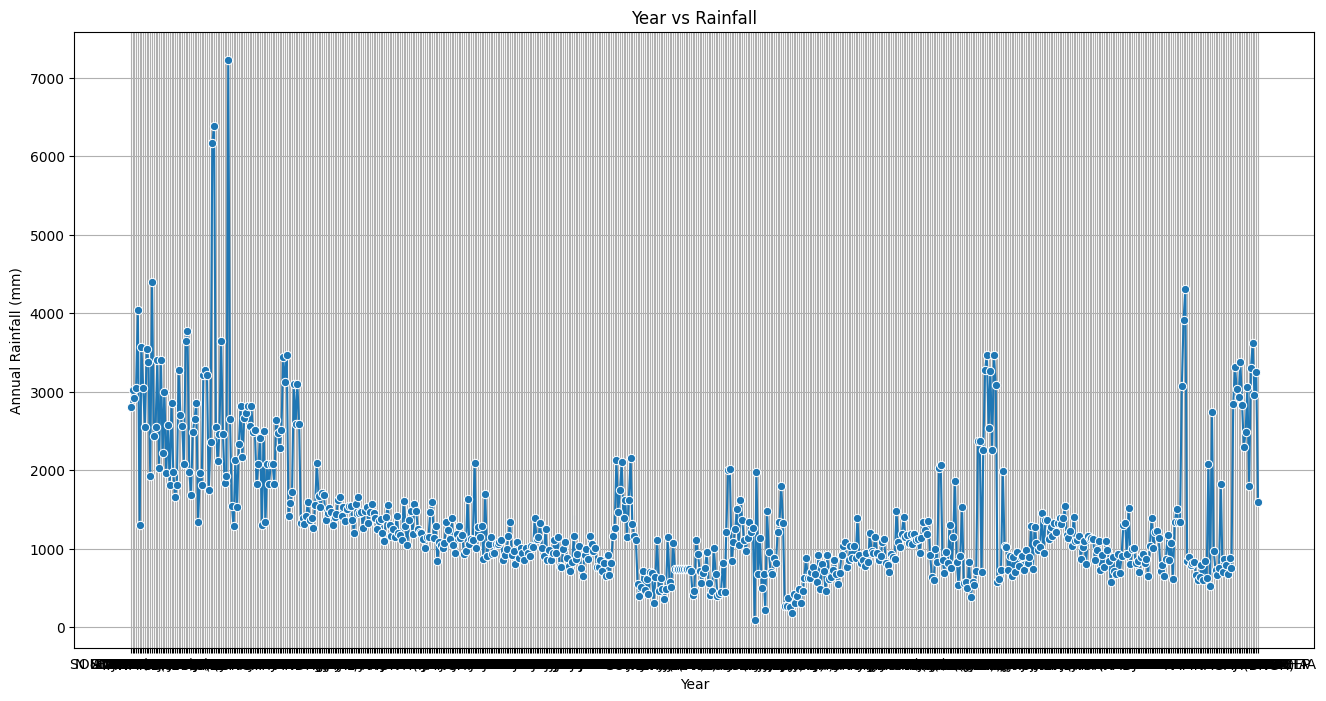

In [ ]:

plt.figure(figsize=(16, 8))
sns.lineplot(data=rainfall_selected, x="DISTRICT", y="ANNUAL", marker="o")
plt.title("Year vs Rainfall")
plt.xlabel("Year")
plt.ylabel("Annual Rainfall (mm)")
plt.grid(True)
plt.show()



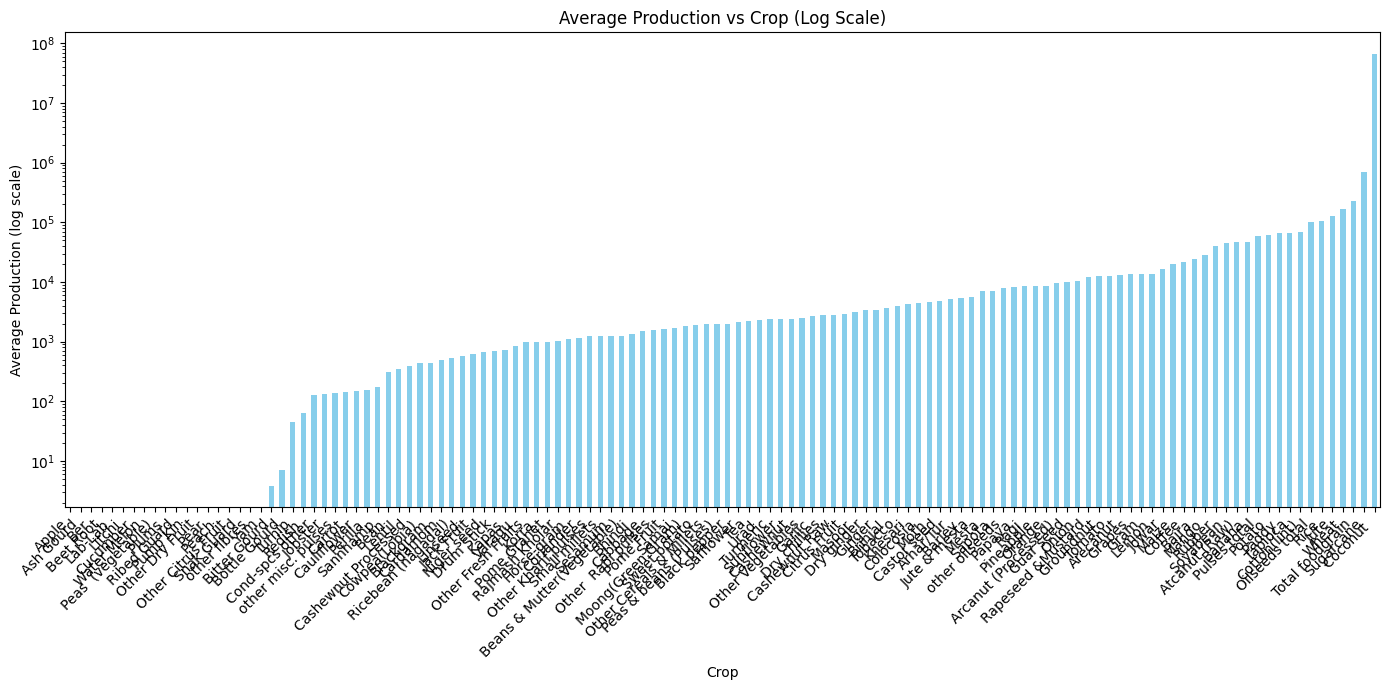

In [ ]:
avg_production_crop = crop_production.groupby("Crop")["Production"].mean().sort_values()
plt.figure(figsize=(14, 7))
avg_production_crop.plot(kind="bar", color="skyblue")
plt.title("Average Production vs Crop (Log Scale)")
plt.ylabel("Average Production (log scale)")
plt.xlabel("Crop")
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


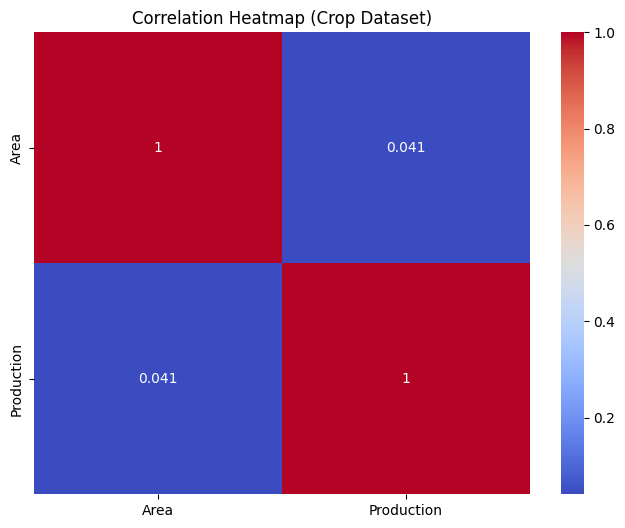

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(crop_production[["Area", "Production"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Crop Dataset)")
plt.show()


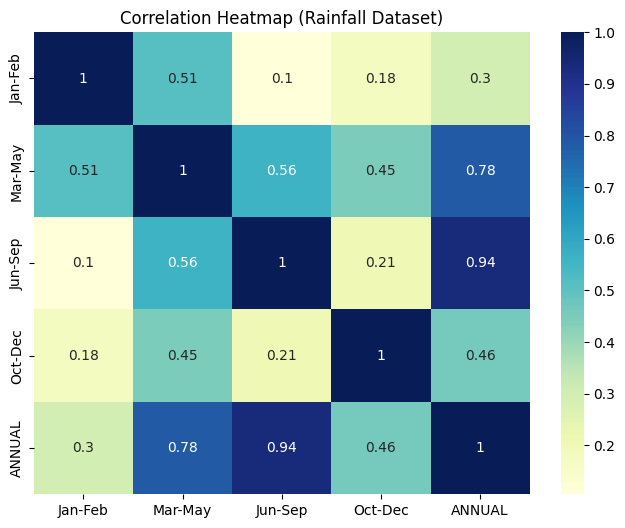

In [ ]:
plt.figure(figsize=(8, 6))
rainfall_corr = rainfall_selected[["Jan-Feb", "Mar-May", "Jun-Sep", "Oct-Dec", "ANNUAL"]].corr()
sns.heatmap(rainfall_corr, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap (Rainfall Dataset)")
plt.show()


# FINAL INTEGRATED CODE

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# -------------------- CLEAN PRODUCTION --------------------
crop_production = crop_production[(crop_production['Area'] > 0) & (crop_production['Production'] > 0)].copy()

# -------------------- FEATURE SELECTION --------------------
crop_reco_df = crop_recommendation[['N','P','K','temperature','humidity','ph','rainfall','label']].copy()
crop_prod_df = crop_production[['Crop_Year','Season','Crop','Area','Production']].copy()
rain_df = rainfall_data[['STATE_UT_NAME','DISTRICT','ANNUAL','Jan-Feb','Mar-May','Jun-Sep','Oct-Dec']].copy()

# -------------------- COMPUTE YIELD --------------------
# Yield in kg/ha
crop_prod_df['Yield'] = (crop_prod_df['Production'] * 1000) / crop_prod_df['Area']

# -------------------- ENCODERS --------------------
# Location encoders for rainfall/status
state_encoder = LabelEncoder()
district_encoder = LabelEncoder()
rain_df['STATE_enc'] = state_encoder.fit_transform(rain_df['STATE_UT_NAME'])
rain_df['DIST_enc'] = district_encoder.fit_transform(rain_df['DISTRICT'])

# Crop recommendation target encoder
crop_label_encoder = LabelEncoder()
crop_reco_df['Encoded_label'] = crop_label_encoder.fit_transform(crop_reco_df['label'])

# Yield model encoders
le_crop = LabelEncoder()
le_state = LabelEncoder()
le_season = LabelEncoder()

# Ensure State_Name exists
if 'State_Name' in crop_production.columns:
    crop_prod_df['State_Name'] = crop_production['State_Name'].copy()
else:
    crop_prod_df['State_Name'] = "UNKNOWN"

# Encode categorical columns
crop_prod_df['Crop_enc'] = le_crop.fit_transform(crop_prod_df['Crop'])
crop_prod_df['State_enc'] = le_state.fit_transform(crop_prod_df['State_Name'])
crop_prod_df['Season_enc'] = le_season.fit_transform(crop_prod_df['Season'])

# -------------------- FINAL YIELD FEATURES --------------------
yield_X = crop_prod_df[['State_enc','Crop_enc','Season_enc','Area','Crop_Year']].copy()
yield_y = crop_prod_df['Yield'].copy()

# Optional: MinMaxScaler for yield (if planning to scale for XGB)
scaler_y = MinMaxScaler()
yield_y_scaled = scaler_y.fit_transform(yield_y.values.reshape(-1,1))


In [ ]:
# -------------------- MODEL TRAINING --------------------

# 1) Rainfall predictor (Random Forest Regressor)
rain_X = rain_df[['STATE_enc','DIST_enc','Jan-Feb','Mar-May','Jun-Sep','Oct-Dec']].copy()
rain_y = rain_df['ANNUAL'].copy()
Xr_train, Xr_test, yr_train, yr_test = train_test_split(rain_X, rain_y, test_size=0.2, random_state=42)

rf_rainfall = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_rainfall.fit(Xr_train, yr_train)

# Optional evaluation
yr_pred = rf_rainfall.predict(Xr_test)
print("Rain RF - R2:", round(r2_score(yr_test, yr_pred), 3),
      "MAE:", round(mean_absolute_error(yr_test, yr_pred), 3))


# 2) Rainfall Status classifier (Drought/Normal/Flood)
avg_rain = rain_df['ANNUAL'].mean()
low_th = 0.75 * avg_rain
high_th = 1.25 * avg_rain

def classify_rf_val(v):
    if v < low_th: return "Drought"
    if v > high_th: return "Flood"
    return "Normal"

rain_df['Rainfall_Status'] = rain_df['ANNUAL'].apply(classify_rf_val)

status_encoder = LabelEncoder()
rain_df['Status_enc'] = status_encoder.fit_transform(rain_df['Rainfall_Status'])

status_X = rain_df[['STATE_enc','DIST_enc','Jan-Feb','Mar-May','Jun-Sep','Oct-Dec']].copy()
status_y = rain_df['Status_enc'].copy()

Xs_train, Xs_test, ys_train, ys_test = train_test_split(status_X, status_y, test_size=0.2, random_state=42)

rf_status = RandomForestClassifier(n_estimators=150, random_state=42)
rf_status.fit(Xs_train, ys_train)

ys_pred = rf_status.predict(Xs_test)
print("Rain Status RF - Acc:", round(accuracy_score(ys_test, ys_pred), 3))


# 3) Crop recommendation (XGBoost Classifier)
crop_X = crop_reco_df[['N','P','K','temperature','humidity','ph','rainfall']].copy()
crop_y = crop_reco_df['Encoded_label'].copy()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    crop_X, crop_y, test_size=0.2, random_state=42, stratify=crop_y
)

xgb_crop = XGBClassifier(
    n_estimators=150, learning_rate=0.1, max_depth=6,
    random_state=42, use_label_encoder=False, eval_metric='mlogloss'
)
xgb_crop.fit(Xc_train, yc_train)

yc_pred = xgb_crop.predict(Xc_test)
print("Crop XGB - Acc:", round(accuracy_score(yc_test, yc_pred), 3))


# 4) Yield prediction (XGBoost Regressor)
yield_X = crop_prod_df[['State_enc','Crop_enc','Season_enc','Area','Crop_Year']].copy()
yield_y = crop_prod_df['Yield'].copy()

# Clip extreme outliers to 99.5 percentile to avoid unrealistic predictions
yield_y = np.clip(yield_y, 0, np.percentile(yield_y, 99.5))

Xy_train, Xy_test, yy_train, yy_test = train_test_split(
    yield_X, yield_y, test_size=0.2, random_state=42
)

xgb_yield = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    random_state=42, objective='reg:squarederror'
)
xgb_yield.fit(Xy_train, yy_train)

yy_pred = xgb_yield.predict(Xy_test)
print("Yield XGB - R2:", round(r2_score(yy_test, yy_pred), 3),
      "MAE:", round(mean_absolute_error(yy_test, yy_pred), 3))


Rain RF - R2: 0.975 MAE: 59.125
Rain Status RF - Acc: 0.953


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:12:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Crop XGB - Acc: 0.989
Yield XGB - R2: 0.924 MAE: 1357.818


In [ ]:
# -------------------- HELPER: safe_transform --------------------
def safe_transform(encoder, value):
    """Transform value using LabelEncoder; add unseen classes if necessary."""
    if value in encoder.classes_:
        return int(encoder.transform([value])[0])
    else:
        encoder.classes_ = np.append(encoder.classes_, value)
        return int(encoder.transform([value])[0])

# -------------------- FINAL INTEGRATED PREDICTION FUNCTION --------------------
def predict_agri(N, P, K, temperature, humidity, ph,
                 state_name, district_name,
                 season_name, area, crop_year,
                 jan_feb, mar_may, jun_sep, oct_dec):

    # --- Step 1: Encode location ---
    state_enc = safe_transform(state_encoder, state_name)
    dist_enc = safe_transform(district_encoder, district_name)

    # --- Step 2: Predict annual rainfall ---
    rain_input_df = pd.DataFrame([[state_enc, dist_enc, jan_feb, mar_may, jun_sep, oct_dec]],
                                 columns=['STATE_enc','DIST_enc','Jan-Feb','Mar-May','Jun-Sep','Oct-Dec'])
    pred_annual = float(rf_rainfall.predict(rain_input_df)[0])

    # --- Step 3: Predict rainfall status ---
    status_input_df = rain_input_df.copy()
    status_pred_enc = int(rf_status.predict(status_input_df)[0])
    status_pred = status_encoder.inverse_transform([status_pred_enc])[0]

    # --- Step 4: Recommend crop ---
    crop_rain = float(np.clip(pred_annual, crop_X['rainfall'].min(), crop_X['rainfall'].max()))
    crop_df = pd.DataFrame([[N, P, K, temperature, humidity, ph, crop_rain]],
                           columns=['N','P','K','temperature','humidity','ph','rainfall'])
    crop_pred_enc = int(xgb_crop.predict(crop_df)[0])
    crop_pred_name = crop_label_encoder.inverse_transform([crop_pred_enc])[0]

    # --- Step 5: Predict yield ---
    state_y_enc = safe_transform(le_state, state_name)
    crop_y_enc = safe_transform(le_crop, crop_pred_name)
    season_y_enc = safe_transform(le_season, season_name)

    yield_df = pd.DataFrame([[state_y_enc, crop_y_enc, season_y_enc, area, crop_year]],
                            columns=['State_enc','Crop_enc','Season_enc','Area','Crop_Year'])

    pred_yield = float(xgb_yield.predict(yield_df)[0])
    # Clip yield to 99.5 percentile of training data
    pred_yield = float(np.clip(pred_yield, 0, np.percentile(yield_y, 99.5)))

    return {
        "Predicted Annual Rainfall (mm)": round(pred_annual, 2),
        "Rainfall Status": status_pred,
        "Recommended Crop": crop_pred_name,
        "Predicted Yield (kg/ha)": round(pred_yield, 2)
    }


In [ ]:
# -------------------- TEST (example) --------------------
test_input = {
    'N': 86, 'P':59 , 'K': 35,
    'temperature': 30, 'humidity': 80, 'ph': 6.946636,
    'state_name': 'Andaman and Nicobar Islands', 'district_name': 'NICOBARS',
    'season_name': 'Rabi', 'area': 23, 'crop_year': 2023,
    'jan_feb': 35.8, 'mar_may': 509.4, 'jun_sep': 1705.7, 'oct_dec': 306.7
}

out = predict_agri(**test_input)
print("\n Integrated Agricultural Prediction")
print(out)



 Integrated Agricultural Prediction
{'Predicted Annual Rainfall (mm)': 2532.1, 'Rainfall Status': 'Flood', 'Recommended Crop': 'rice', 'Predicted Yield (kg/ha)': 2719.38}


In [ ]:
import joblib

# Save only the models used in integration
joblib.dump(rf_rainfall, "rf_rainfall.pkl")
joblib.dump(rf_status, "rf_status.pkl")
joblib.dump(xgb_crop, "xgb_crop.pkl")
joblib.dump(xgb_yield, "xgb_yield.pkl")

print("✅ Models saved successfully as .pkl files")


✅ Models saved successfully as .pkl files


In [ ]:
from google.colab import files

files.download("rf_rainfall.pkl")
files.download("rf_status.pkl")
files.download("xgb_crop.pkl")
files.download("xgb_yield.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# INDIVIDUAL MODELS

# rainfall prediction

using random forest regressor

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create encoders
state_encoder = LabelEncoder()
district_encoder = LabelEncoder()

# Apply encoding to rainfall_selected
rainfall_selected['STATE_UT_NAME'] = state_encoder.fit_transform(rainfall_selected['STATE_UT_NAME'])
rainfall_selected['DISTRICT'] = district_encoder.fit_transform(rainfall_selected['DISTRICT'])


/tmp/ipython-input-215911420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_selected['STATE_UT_NAME'] = state_encoder.fit_transform(rainfall_selected['STATE_UT_NAME'])
/tmp/ipython-input-215911420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_selected['DISTRICT'] = district_encoder.fit_transform(rainfall_selected['DISTRICT'])


In [ ]:
X = rainfall_selected.drop(columns=['ANNUAL'])
y = rainfall_selected['ANNUAL']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R² Score: 0.9750075447717895
Mean Absolute Error: 59.1252015503879
Root Mean Squared Error: 149.48969085134124


In [ ]:
results_df = X_test.copy()
results_df['Actual_Annual'] = y_test.values
results_df['Predicted_Annual'] = y_pred
print(results_df.head())


     STATE_UT_NAME  DISTRICT  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec  \
86              34       124     24.9    516.5   2737.6    164.7   
304             12       380     19.0     21.3    501.8     29.9   
434             19       112     30.2     14.4    985.0     51.8   
312              9       570     32.7     43.5    636.2     34.7   
72              24       592     50.5    468.6   1386.1    174.8   

     Actual_Annual  Predicted_Annual  
86          3443.7         3370.0045  
304          572.0          593.2610  
434         1081.4         1096.5400  
312          747.1          746.8060  
72          2080.0         2075.1685  


USING XG BOOST

In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R² Score: {r2_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost R² Score: 0.9813770505851747
XGBoost MAE: 60.39681112599927
XGBoost RMSE: 129.04197880891684


In [ ]:
# Create a DataFrame to compare actual vs predicted (XGBoost)
results_xgb_df = X_test.copy()
results_xgb_df['Actual_Annual'] = y_test.values
results_xgb_df['Predicted_Annual_XGB'] = y_pred_xgb

print(results_xgb_df.head())


     STATE_UT_NAME  DISTRICT  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec  \
86              34       124     24.9    516.5   2737.6    164.7   
304             12       380     19.0     21.3    501.8     29.9   
434             19       112     30.2     14.4    985.0     51.8   
312              9       570     32.7     43.5    636.2     34.7   
72              24       592     50.5    468.6   1386.1    174.8   

     Actual_Annual  Predicted_Annual_XGB  
86          3443.7           3364.872314  
304          572.0            584.040222  
434         1081.4           1096.091675  
312          747.1            747.725769  
72          2080.0           2073.884521  


# drought and flood prediction

using random forest using threshold

In [ ]:
# --- DROUGHT AND FLOOD PREDICTION USING RANDOM FOREST ---

# Calculate long-term average rainfall
avg_rainfall = rainfall_selected['ANNUAL'].mean()

# Define thresholds
low_threshold = 0.75 * avg_rainfall
high_threshold = 1.25 * avg_rainfall

# Create Rainfall_Status column based on ANNUAL
def classify_rainfall(rainfall):
    if rainfall < low_threshold:
        return "Drought"
    elif rainfall > high_threshold:
        return "Flood"
    else:
        return "Normal"

rainfall_selected['Rainfall_Status'] = rainfall_selected['ANNUAL'].apply(classify_rainfall)
print("\nClass Distribution:\n", rainfall_selected['Rainfall_Status'].value_counts())

# Encode Rainfall_Status
from sklearn.preprocessing import LabelEncoder
status_encoder = LabelEncoder()
rainfall_selected['Encoded_Status'] = status_encoder.fit_transform(rainfall_selected['Rainfall_Status'])

# --- FIX: Remove ANNUAL to avoid leakage ---
X = rainfall_selected.drop(columns=['ANNUAL', 'Rainfall_Status'])
y = rainfall_selected['Encoded_Status']

# Encode STATE_UT_NAME and DISTRICT
X['STATE_UT_NAME'] = LabelEncoder().fit_transform(X['STATE_UT_NAME'])
X['DISTRICT'] = LabelEncoder().fit_transform(X['DISTRICT'])

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict
y_pred = rf_classifier.predict(X_test)

# Evaluate
print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=status_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Class Distribution:
 Rainfall_Status
Drought    267
Normal     243
Flood      131
Name: count, dtype: int64


/tmp/ipython-input-4240916024.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_selected['Rainfall_Status'] = rainfall_selected['ANNUAL'].apply(classify_rainfall)
/tmp/ipython-input-4240916024.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_selected['Encoded_Status'] = status_encoder.fit_transform(rainfall_selected['Rainfall_Status'])



--- Random Forest Results ---
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

     Drought       1.00      1.00      1.00        52
       Flood       1.00      1.00      1.00        32
      Normal       1.00      1.00      1.00        45

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129


Confusion Matrix:
 [[52  0  0]
 [ 0 32  0]
 [ 0  0 45]]


using xg boost

In [ ]:
# --- DROUGHT AND FLOOD PREDICTION USING XGBOOST ---

# (Reuse same Rainfall_Status as above)

# Encode Rainfall_Status
status_encoder = LabelEncoder()
rainfall_selected['Encoded_Status'] = status_encoder.fit_transform(rainfall_selected['Rainfall_Status'])

# --- FIX: Remove ANNUAL to avoid leakage ---
X = rainfall_selected.drop(columns=['ANNUAL', 'Rainfall_Status'])
y = rainfall_selected['Encoded_Status']

# Encode STATE_UT_NAME and DISTRICT
X['STATE_UT_NAME'] = LabelEncoder().fit_transform(X['STATE_UT_NAME'])
X['DISTRICT'] = LabelEncoder().fit_transform(X['DISTRICT'])

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train
xgb_classifier.fit(X_train, y_train)

# Predict
y_pred = xgb_classifier.predict(X_test)

# Evaluate
print("\n--- XGBoost Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=status_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Results DataFrame
results_df = X_test.copy()
results_df['Actual_Status'] = status_encoder.inverse_transform(y_test)
results_df['Predicted_Status'] = status_encoder.inverse_transform(y_pred)
print("\n--- Sample Predictions ---")
print(results_df.head())


/tmp/ipython-input-2476889834.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_selected['Encoded_Status'] = status_encoder.fit_transform(rainfall_selected['Rainfall_Status'])
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:12:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Results ---
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

     Drought       1.00      1.00      1.00        52
       Flood       1.00      1.00      1.00        32
      Normal       1.00      1.00      1.00        45

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129


Confusion Matrix:
 [[52  0  0]
 [ 0 32  0]
 [ 0  0 45]]

--- Sample Predictions ---
     STATE_UT_NAME  DISTRICT  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec  \
86              34       124     24.9    516.5   2737.6    164.7   
304             12       380     19.0     21.3    501.8     29.9   
434             19       112     30.2     14.4    985.0     51.8   
312              9       570     32.7     43.5    636.2     34.7   
72              24       592     50.5    468.6   1386.1    174.8   

     Encoded_Status Actual_Status Predicted_Status  
86      

# crop recommendation

In [ ]:
# --- IMPORTS ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# --- DATA PREPARATION ---
# Using already selected dataset: crop_recommendation_selected
# Inputs: N, P, K, temperature, humidity, ph, rainfall
# Target: label

X = crop_recommendation_selected[['N','P','K','temperature','humidity','ph','rainfall']]
y = crop_recommendation_selected['label']

# Encode labels (crop names)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


random forest

In [ ]:
# --- RANDOM FOREST CLASSIFIER ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))



--- Random Forest Results ---
Accuracy: 0.9931818181818182

Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00       

xg boost

In [ ]:
# --- XGBOOST CLASSIFIER ---
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("\n--- XGBoost Results ---")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:12:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Results ---
Accuracy: 0.9863636363636363

Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        14
        jute       0.96      0.96      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       0.95      1.00      0.97        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
  

In [ ]:
# --- SAVE PREDICTIONS FOR ANALYSIS ---
results_df = X_test.copy()
results_df['Actual_Crop'] = label_encoder.inverse_transform(y_test)
results_df['Predicted_Crop_RF'] = label_encoder.inverse_transform(rf_pred)
results_df['Predicted_Crop_XGB'] = label_encoder.inverse_transform(xgb_pred)
print("\nSample Predictions:")
print(results_df.head())



Sample Predictions:
        N    P    K  temperature   humidity        ph    rainfall Actual_Crop  \
1451  101   17   47    29.494014  94.729813  6.185053   26.308209   muskmelon   
1334   98    8   51    26.179346  86.522581  6.259336   49.430510  watermelon   
1761   59   62   49    43.360515  93.351916  6.941497  114.778071      papaya   
1735   44   60   55    34.280461  90.555616  6.825371   98.540477      papaya   
1576   30  137  200    22.914300  90.704756  5.603413  118.604465       apple   

     Predicted_Crop_RF Predicted_Crop_XGB  
1451         muskmelon          muskmelon  
1334        watermelon         watermelon  
1761            papaya             papaya  
1735            papaya             papaya  
1576             apple              apple  


# yield prediction

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Step 1: Load dataset
data = pd.read_csv("crop_production.csv")

# Step 2: Filter out invalid rows
data = data[(data['Area'] > 0) & (data['Production'] > 0)]

# Step 3: Calculate Yield (kg/ha)
data['Yield'] = (data['Production'] * 1000) / data['Area']

# Step 4: Encode categorical variables
le_crop = LabelEncoder()
data['Crop'] = le_crop.fit_transform(data['Crop'])

le_state = LabelEncoder()
data['State_Name'] = le_state.fit_transform(data['State_Name'])

le_season = LabelEncoder()
data['Season'] = le_season.fit_transform(data['Season'])

# Step 5: Define Features & Target
features = ['State_Name', 'Crop', 'Season', 'Area', 'Crop_Year']
X = data[features]
y = data['Yield']

# Step 6: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# ------------------ RANDOM FOREST ------------------
print("\n--- Random Forest ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf) ** 0.5  # Fixed RMSE calculation
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {rf_mae:.2f} kg/ha")
print(f"RMSE: {rf_rmse:.2f} kg/ha")
print(f"R² Score: {rf_r2:.2f}")



--- Random Forest ---
MAE: 9041.86 kg/ha
RMSE: 212185.33 kg/ha
R² Score: 0.88


In [ ]:
# ------------------ XGBOOST ------------------
print("\n--- XGBoost ---")
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


--- XGBoost ---


In [ ]:
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb) ** 0.5  # Fixed RMSE
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"MAE: {xgb_mae:.2f} kg/ha")
print(f"RMSE: {xgb_rmse:.2f} kg/ha")
print(f"R² Score: {xgb_r2:.2f}")

MAE: 18128.28 kg/ha
RMSE: 236938.59 kg/ha
R² Score: 0.85


In [ ]:
# Show predicted vs actual yields
output_df = X_test.copy()
output_df['Actual_Yield'] = y_test
output_df['Predicted_Yield_RF'] = y_pred_rf  # For Random Forest
# OR for XGBoost: output_df['Predicted_Yield_XGB'] = y_pred_xgb

print("\nSample Predictions:")
print(output_df.head(10))



Sample Predictions:
        State_Name  Crop  Season     Area  Crop_Year  Actual_Yield  \
41416            4    90       4     26.0       1997  42961.538462   
183710          27     2       1    320.0       2010    650.000000   
71982           11    90       4     56.0       2001   1035.714286   
125632          17   102       2  38900.0       2012   1185.089974   
180040          27    34       4     41.0       1999   5634.146341   
146009          21    29       1     40.0       2001    750.000000   
103321          16    34       4    111.0       2004   3441.441441   
78509           14    40       1  12063.0       2000    403.713836   
23730            3    87       1    249.0       2014    698.795181   
190906          27    80       1  24139.0       2003   1821.782178   

        Predicted_Yield_RF  
41416         69131.155000  
183710          676.055211  
71982          4323.154121  
125632         1508.986871  
180040         5609.897648  
146009          914.658885  
10332